In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import mplhep as hep
from scipy.optimize import curve_fit
import pandas as pd

plt.style.use(hep.style.ROOT)

### user defined

In [118]:
### Variables used in software
baseline = 50
#16/12/2022 14:10
import time
#help(time)
starttime=time.struct_time((2022, 12, 16, 14, 10,0,-1,-1,-1))

renameChannels=False

In [119]:
with open('Run8_list.txt') as f:
    lines = f.read().split('\n')
tags = None
channels =[]
din={"timestamp":[], "trigID":[]}
#din.update({f"timestamp_{unit}":[] for unit in "year month day hour minute"})
for line in lines:
    if line[:2]=="//" or len(line)==0:
        continue
    #first line after comments
    if tags is None:
        tags = line.split()
        tags=tags[-3:]
        continue
    split = line.split()
    
    if len(split)== 6:
        timestamp_us=float(split[0])
        din['timestamp'].append(timestamp_us)
        trigID=int(split[1])
        din['trigID'].append(trigID)
    
    channel, LG, HG = split[-3:]
    if channel not in channels:
        din[f"Ch_{channel}_LG"] = []
        din[f"Ch_{channel}_HG"] = []
        channels.append(channel)
    din[f"Ch_{channel}_LG"].append(float(LG)-baseline)
    din[f"Ch_{channel}_HG"].append(float(HG)-baseline)
df = pd.DataFrame(din)


if renameChannels:
    new_channels=[]
    for ch in reversed(channels):
        newname=str(int(ch)+1)
        if len(newname)==1:
            newname="0"+newname
        df = df.rename({f"Ch_{ch}_LG":f"Ch_{newname}_LG", f"Ch_{ch}_HG":f"Ch_{newname}_HG"}, axis=1)
        new_channels.append(newname)
    channels=list(reversed(new_channels))
    

print(f"Done! Total events: {len(df)}")
print(f"channels in df are:  {channels}")

Done! Total events: 77447
channels in df are:  ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11']


In [166]:
def Landau(x, normalization,location,stdev):
    #print(type(x))
    u=(x-location)*3.591/stdev/2.355
    renormalization = 1.64872*normalization
    return renormalization * np.exp(-u/2 - np.exp(-u)/2)

def LandauPlusGauss(x, normalization,location,stdev, a, mu, sigma):
    u=(x-location)*3.591/stdev/2.355
    renormalization = 1.64872*normalization
    return renormalization * np.exp(-u/2 - np.exp(-u)/2)+a*np.exp(-(x-mu)**2/(2*sigma**2))

def Gauss(x, a, mu, sigma):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

chi2= 2.3678442789504145e-29 ndof= 8 pval= 1.0
chi2= 21.96987890133857 ndof= 8 pval= 0.004971973164321755
chi2= 28.138978164122765 ndof= 8 pval= 0.0004485315976350821
chi2= 31.228362462509864 ndof= 8 pval= 0.00012794247587391235
chi2= 32.02059774476717 ndof= 8 pval= 9.23537135074996e-05
chi2= 42.72654712765309 ndof= 8 pval= 9.889574960334186e-07
chi2= 14.516544462060539 ndof= 8 pval= 0.06925631194386979
chi2= 26.065813130731392 ndof= 8 pval= 0.001023406268763454
chi2= 42.345454178161816 ndof= 8 pval= 1.1663497794064276e-06
chi2= 21.943462669421713 ndof= 8 pval= 0.005021686191955187
chi2= 2.3678442789504145e-29 ndof= 8 pval= 1.0
chi2= 43.602614487618794 ndof= 8 pval= 6.76257705498107e-07
5
58.07692307692308


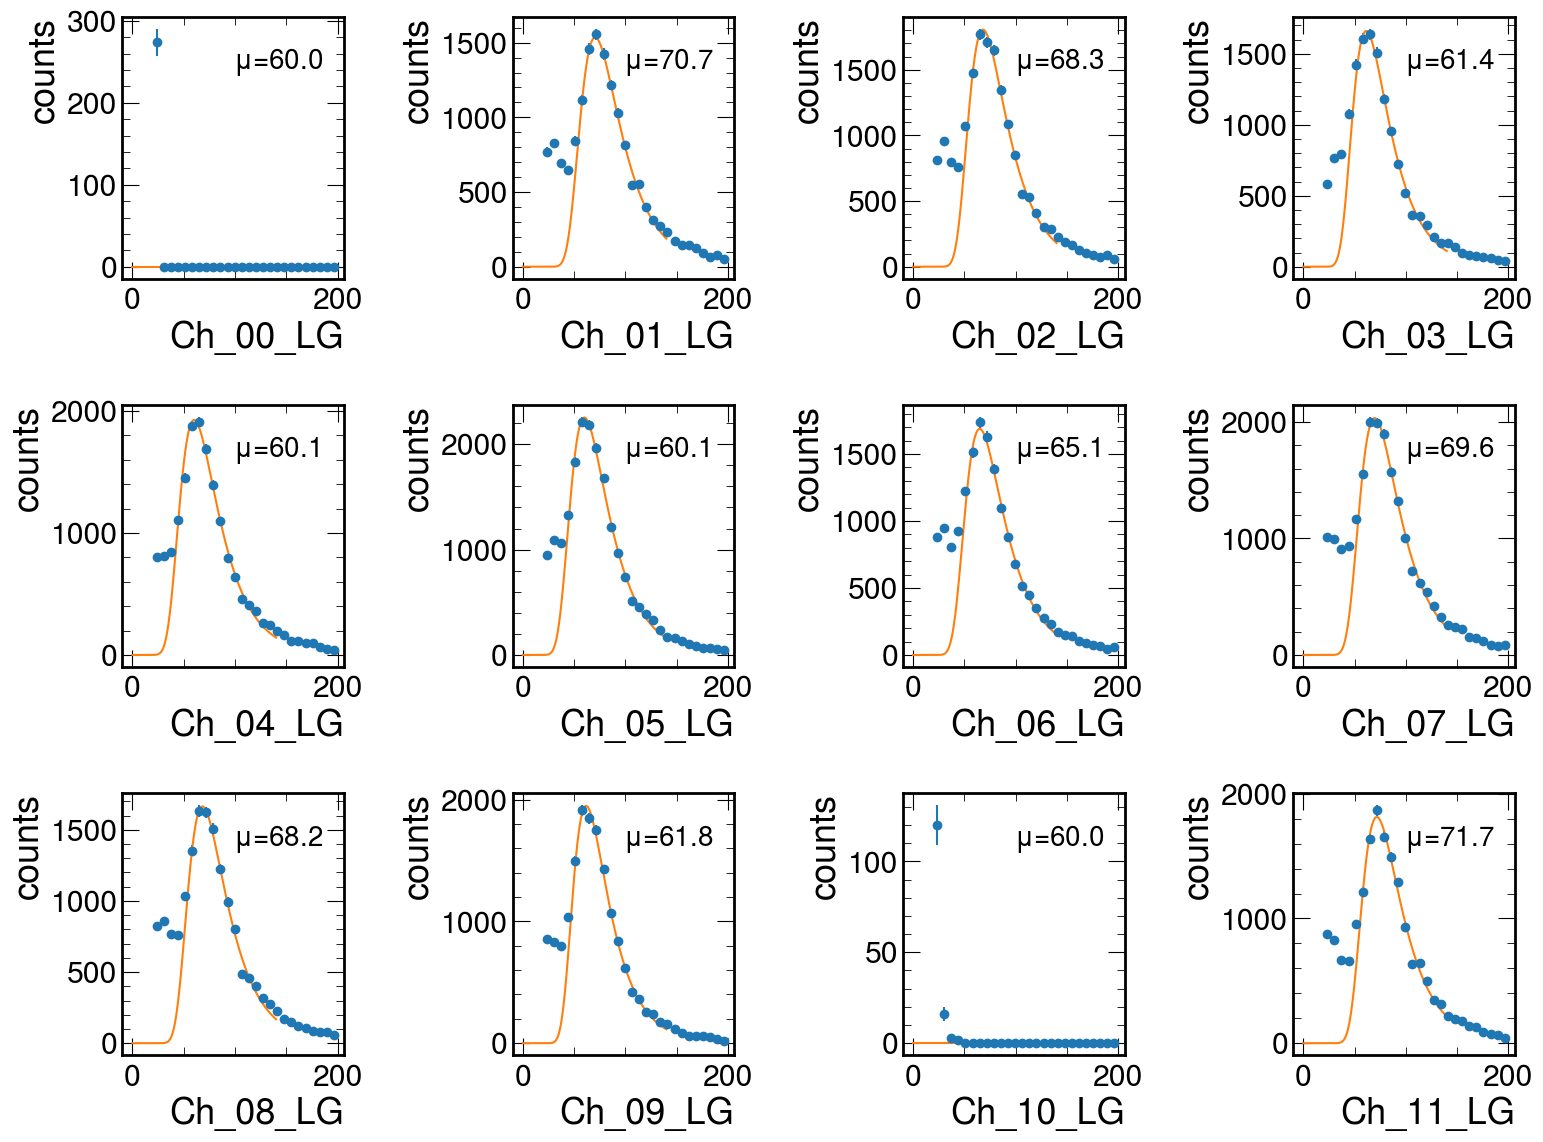

In [167]:
fig, axs=plt.subplots(3,4, figsize=(16, 16/4*3))

for i in range(len(channels)):
    ch = channels[i]
    plt.sca(axs[i//4][i%4])
    hist,x,= np.histogram(df.eval(f"Ch_{ch}_LG"), bins=26, range=(20,200))
    plt.xlabel(f"Ch_{ch}_LG")
    plt.ylabel("counts")
    
    bin_centers=(x[1:]+x[:-1])/2
    
    from scipy.optimize import curve_fit
    start,stop=5,-10
    p0=[1000, 60, 10]
    
    plt.errorbar(bin_centers, hist, np.sqrt(hist), linestyle='', marker='o', label='data')
    
    dhist=np.sqrt(hist[start:stop])+(hist[start:stop]==0)
    coeff, var_matrix = curve_fit(Landau, bin_centers[start:stop], hist[start:stop], p0=p0,
                             sigma=dhist)
    from scipy.stats import chi2
    chi2val = sum((Landau(bin_centers[start:stop], *coeff)-hist[start:stop])**2/dhist**2)
    ndof = len(bin_centers[start:stop])-len(coeff)
    print("chi2=",chi2val, "ndof=",ndof, "pval=", chi2.sf(chi2val, ndof))
    x=np.linspace(0, 140, 280)
    mu=coeff[1]

    curve = plt.plot(x, Landau(x,*coeff), label=f"Landau:\n $\\mu$={mu:.1f}")
    #plt.legend(fontsize=12)    
    plt.text(0.5, 0.8, f"$\mu$={mu:.1f}", transform=plt.gca().transAxes, fontsize=20)
plt.tight_layout()
print(start)
print(bin_centers[start])

chi2= 90.84655036141439 ndof= 94 pval= 0.5729261860281264
chi2= 1758.8207113823048 ndof= 94 pval= 6.201288930072493e-305
chi2= 1719.7925713714224 ndof= 94 pval= 6.600619699556197e-297
chi2= 1345.635395972161 ndof= 94 pval= 1.4873149443442824e-220
chi2= 1391.594122003871 ndof= 94 pval= 7.28556135954263e-230
chi2= 1310.797087237559 ndof= 94 pval= 1.63780252025394e-213
chi2= 1130.6818276089925 ndof= 94 pval= 2.388110035275141e-177
chi2= 1898.0601627284 ndof= 94 pval= 0.0
chi2= 1620.364944856129 ndof= 94 pval= 1.6665396455597922e-276
chi2= 2201.741305604011 ndof= 94 pval= 0.0
chi2= 115.7749357088327 ndof= 94 pval= 0.06331307609283326
chi2= 2356.1385837414455 ndof= 94 pval= 0.0


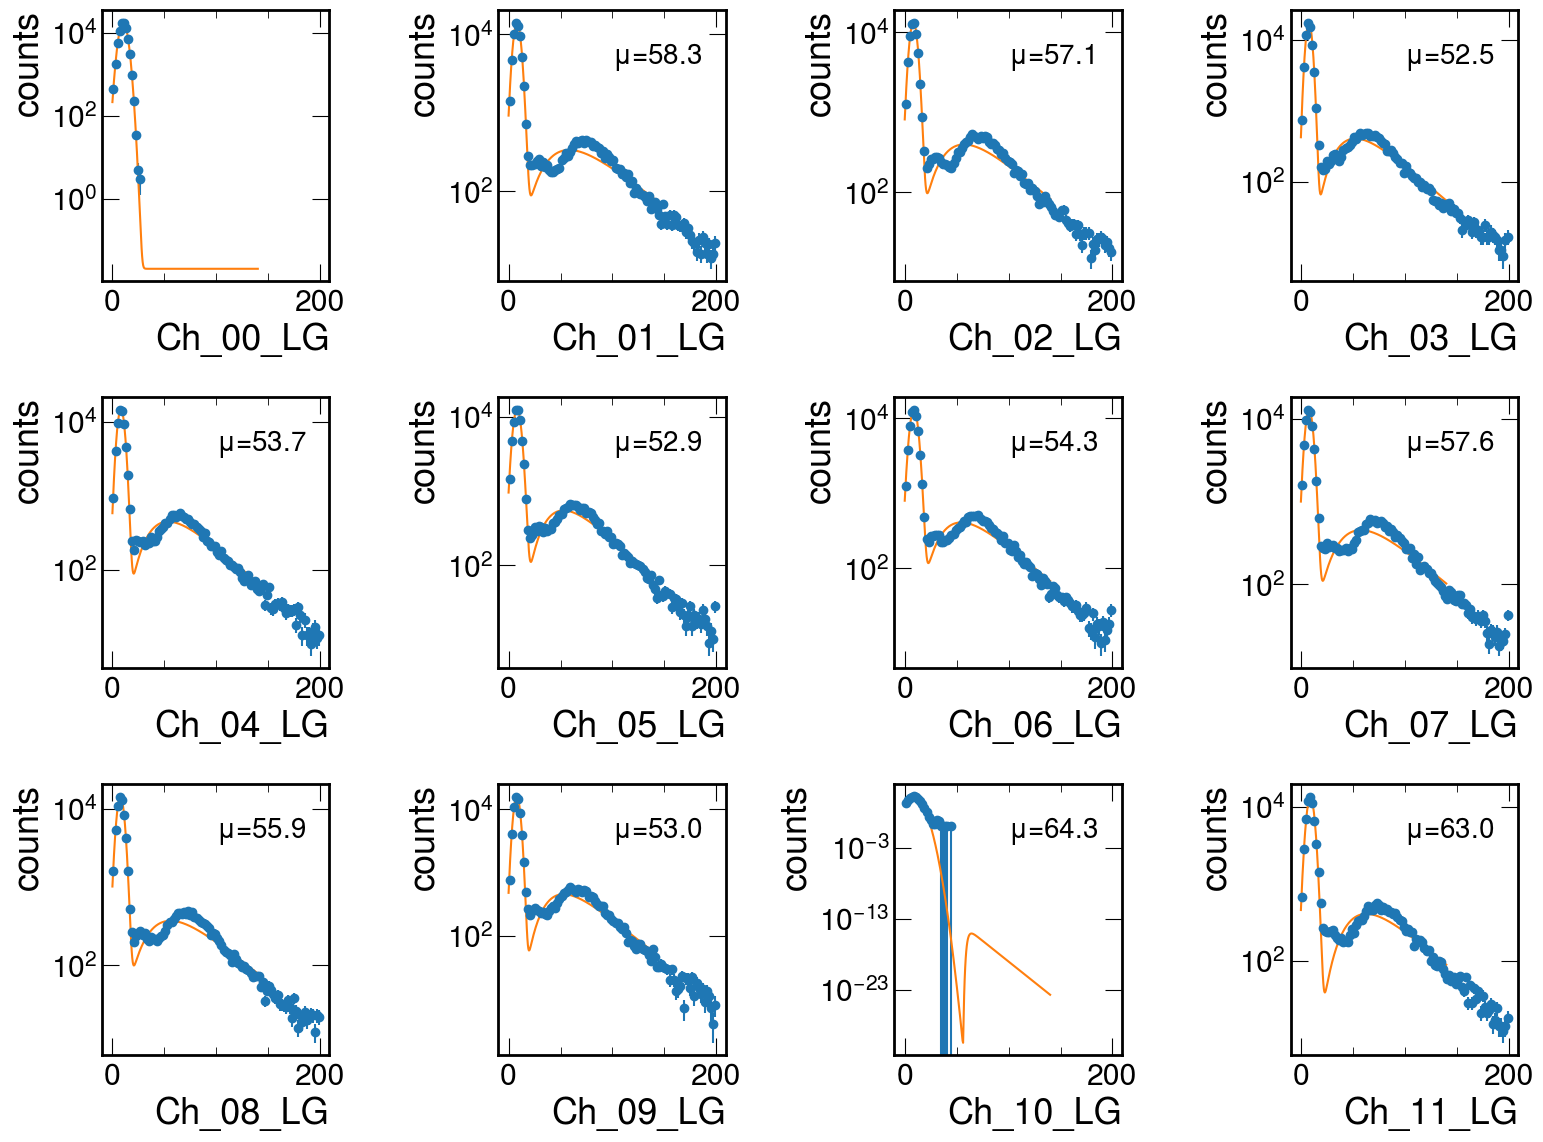

In [173]:
fig, axs=plt.subplots(3,4, figsize=(16, 16/4*3))

for i in range(len(channels)):
    ch = channels[i]
    plt.sca(axs[i//4][i%4])
    hist,x,= np.histogram(df.eval(f"Ch_{ch}_LG"), bins=100, range=(0,200))
    plt.xlabel(f"Ch_{ch}_LG")
    plt.ylabel("counts")
    
    bin_centers=(x[1:]+x[:-1])/2
    
    from scipy.optimize import curve_fit
    start,stop=int(55/(x[1]-x[0])),-10
    p0=[1000, 60, 10]
    
    plt.errorbar(bin_centers, hist, np.sqrt(hist), linestyle='', marker='o', label='data')
    
    dhist=np.sqrt(hist)+(hist==0)
    coeff, var_matrix = curve_fit(Landau, bin_centers[start:stop], hist[start:stop], p0=p0,
                             sigma=dhist[start:stop])
    
    start, stop = 0, int(20/(x[1]-x[0]))
    coeff_g, var_matrix = curve_fit(Gauss, bin_centers[start:stop], hist[start:stop], p0=[10000,10,15],
                             sigma=dhist[start:stop])
    
    coeff, var_matrix = curve_fit(LandauPlusGauss, bin_centers, hist, p0=list(coeff)+list(coeff_g),
                             sigma=dhist)
    
    
    from scipy.stats import chi2
    start,stop=0,None
    chi2val = sum((LandauPlusGauss(bin_centers[start:stop], *coeff)-hist[start:stop])**2/dhist[start:stop]**2)
    ndof = len(bin_centers[start:stop])-len(coeff)
    print("chi2=",chi2val, "ndof=",ndof, "pval=", chi2.sf(chi2val, ndof))
    x=np.linspace(0, 140, 280)
    mu=coeff[1]

    curve = plt.plot(x, LandauPlusGauss(x,*coeff), label=f"Landau:\n $\\mu$={mu:.1f}")
    #plt.legend(fontsize=12)    
    if mu < 100:
        plt.text(0.5, 0.8, f"$\mu$={mu:.1f}", transform=plt.gca().transAxes, fontsize=20)
    plt.yscale('log')
plt.tight_layout()

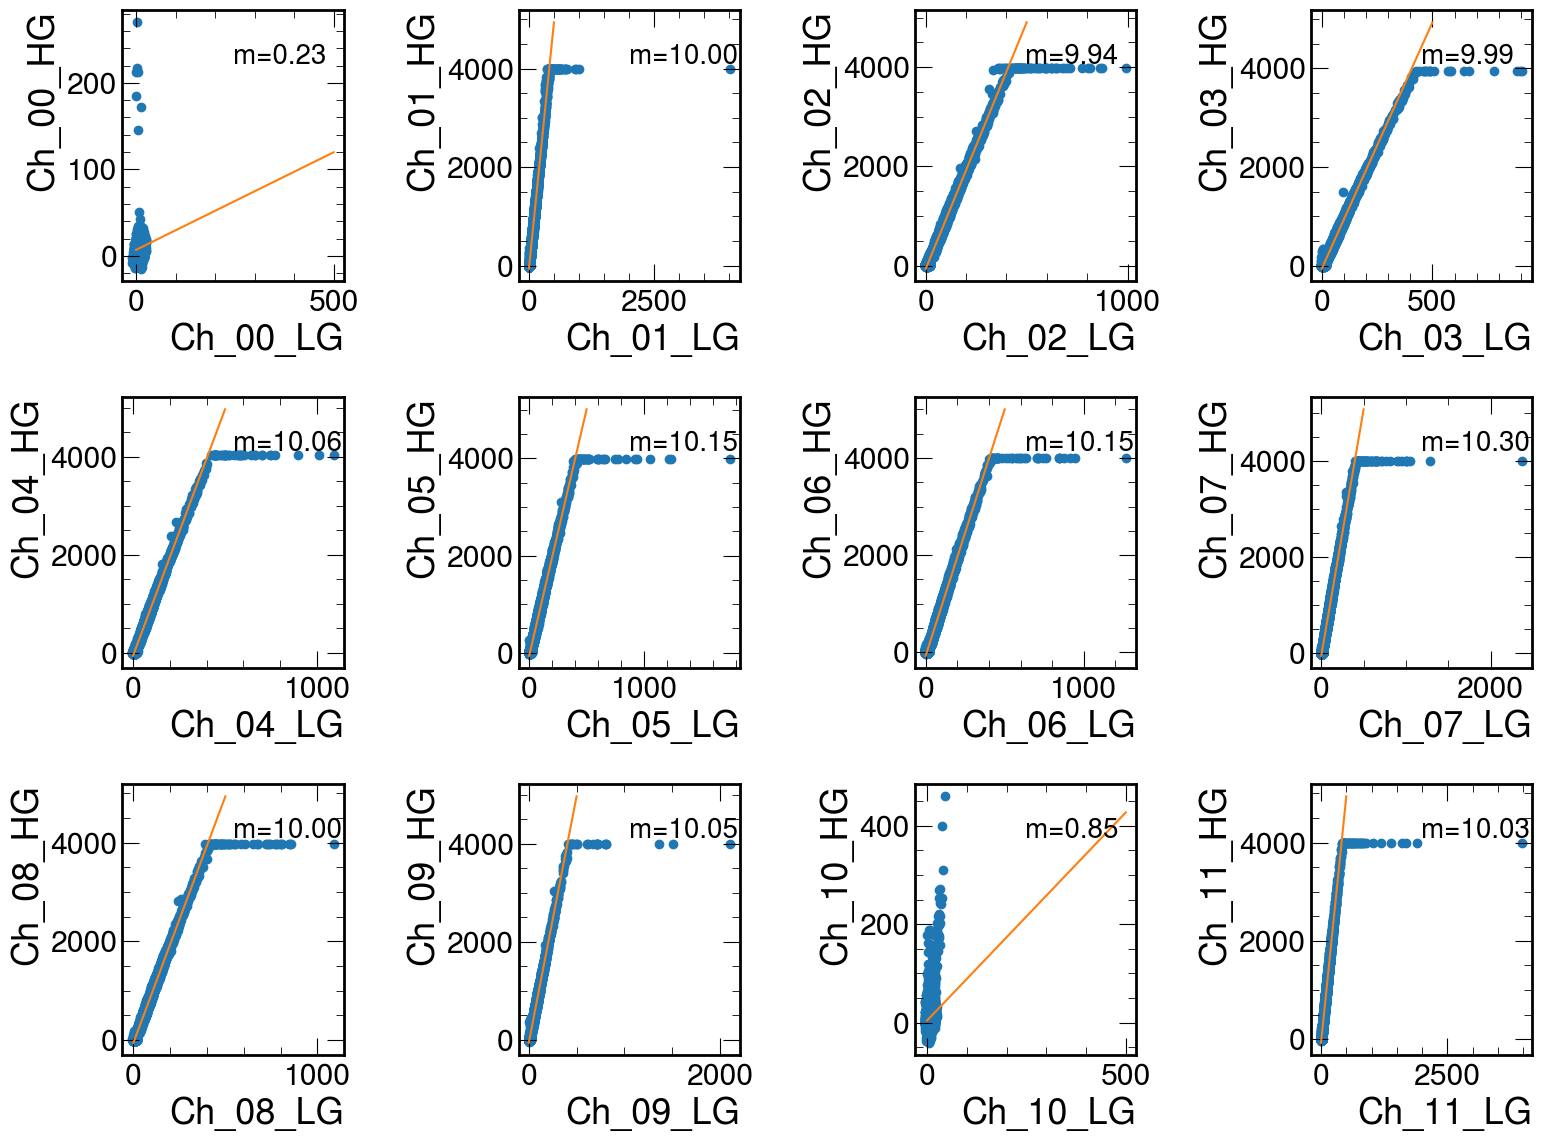

In [179]:
fig, axs=plt.subplots(3,4, figsize=(16, 16/4*3))

for i in range(len(channels)):
    ch = channels[i]
    plt.sca(axs[i//4][i%4])
    plt.scatter(df.eval(f"Ch_{ch}_LG"), df.eval(f"Ch_{ch}_HG"))
    plt.xlabel(f"Ch_{ch}_LG")
    plt.ylabel(f"Ch_{ch}_HG")
    
    x,y= df.query(f"Ch_{ch}_LG<500").eval(f"Ch_{ch}_LG"), df.query(f"Ch_{ch}_LG<500").eval(f"Ch_{ch}_HG")
    
    m=(np.sum(x*y)*len(x)-np.sum(x)*np.sum(y))/(np.sum(x*x)*len(x)-np.sum(x)*np.sum(x))
    b = (sum(y)-m*sum(x))/len(x)
    plt.plot([0, 500], [b, 500*m+b], linestyle='-', color='tab:orange')
    plt.text(0.5, 0.8, f"m={m:.2f}", transform=plt.gca().transAxes, fontsize=20)
    
plt.tight_layout()

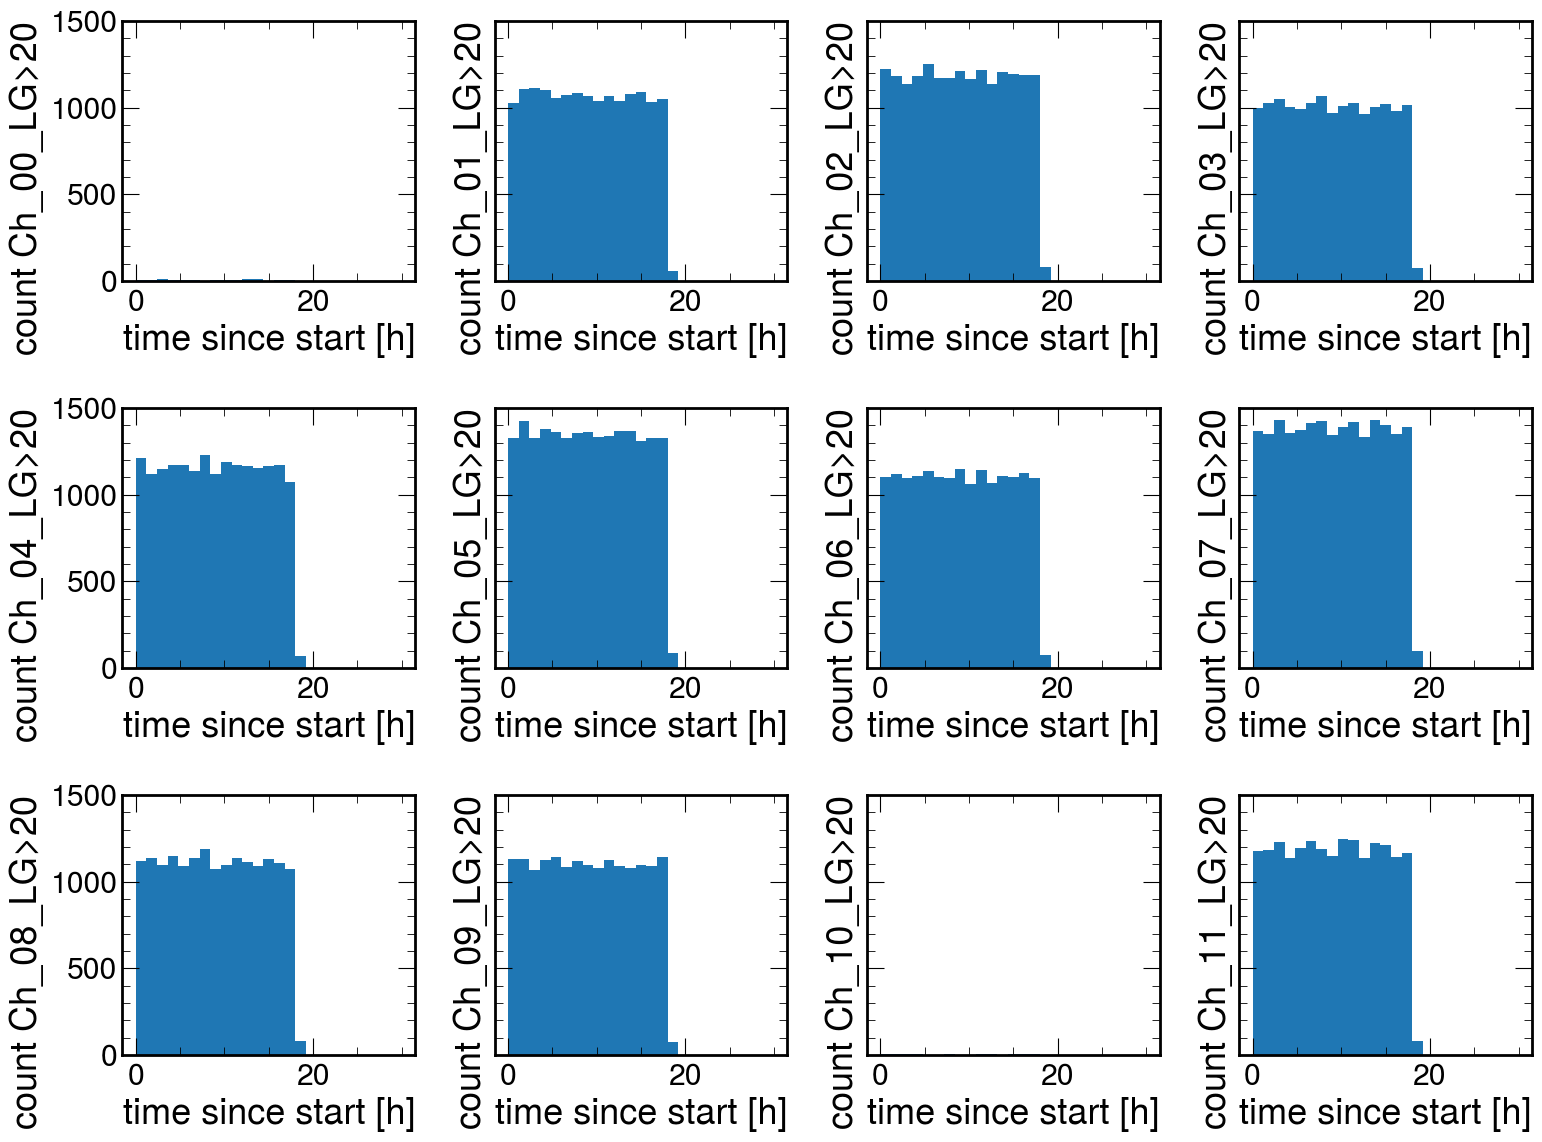

In [123]:
fig, axs=plt.subplots(3,4, figsize=(16, 16/4*3),sharey='all')

for i in range(len(channels)):
    ch = channels[i]
    plt.sca(axs[i//4][i%4])
    plt.hist(df.query(f"Ch_{ch}_LG>20").eval(f"timestamp/3.6e9"), bins=25, range=(0,30))
    plt.xlabel(f"time since start [h]")
    plt.ylabel(f"count Ch_{ch}_LG>20")
plt.tight_layout()

chi2= 2.3678442789504145e-29 ndof= 8 pval= 1.0
chi2= 2.3678442789504145e-29 ndof= 8 pval= 1.0
chi2= 2.3678442789504145e-29 ndof= 8 pval= 1.0
chi2= 2.3678442789504145e-29 ndof= 8 pval= 1.0
chi2= 2.3678442789504145e-29 ndof= 8 pval= 1.0
chi2= 2.3678442789504145e-29 ndof= 8 pval= 1.0
chi2= 2.3678442789504145e-29 ndof= 8 pval= 1.0
chi2= 2.3678442789504145e-29 ndof= 8 pval= 1.0
chi2= 2.3678442789504145e-29 ndof= 8 pval= 1.0
chi2= 2.3678442789504145e-29 ndof= 8 pval= 1.0
chi2= 9.806233257712858 ndof= 8 pval= 0.27889011583876344
chi2= 8.255236775175016 ndof= 8 pval= 0.4089434457466546
chi2= 14.657614399664096 ndof= 8 pval= 0.0661549649980296
chi2= 15.701939132929436 ndof= 8 pval= 0.046850476418595396
chi2= 7.8644478810161775 ndof= 8 pval= 0.4468221876702625
chi2= 7.933120341207299 ndof= 8 pval= 0.44003030683164945
chi2= 7.446877257569675 ndof= 8 pval= 0.4892720586220414
chi2= 8.363220059659604 ndof= 8 pval= 0.3988174842060346
chi2= 7.003933599638099 ndof= 8 pval= 0.5362083207638094
chi2= 7.10

/var/folders/_x/mzz2_hcx0dg4mv6b9blzjpp40000gn/T/ipykernel_1625/2718393448.py:5: RuntimeWarning: overflow encountered in exp
  return renormalization * np.exp(-u/2 - np.exp(-u)/2)


chi2= 3.731296258057927 ndof= 8 pval= 0.880516784780589
chi2= 7.749980886202755 ndof= 8 pval= 0.45826608114448264
chi2= 4.6161909113838036 ndof= 8 pval= 0.7976991594161078
chi2= 4.19722794423223 ndof= 8 pval= 0.838904746245924
chi2= 4.528427732779052 ndof= 8 pval= 0.8065823087580508
chi2= 19.41306533362961 ndof= 8 pval= 0.012800020541882529
chi2= 3.1309308864869108 ndof= 8 pval= 0.9258740502337228
chi2= 17.253783629708863 ndof= 8 pval= 0.027572305681061997
chi2= 12.428545037482897 ndof= 8 pval= 0.13308294664068965
chi2= 15.377995772966573 ndof= 8 pval= 0.05219910454046191
chi2= 4.806077271197688 ndof= 8 pval= 0.7780875523672163
chi2= 15.08318386841782 ndof= 8 pval= 0.057548041185443446
chi2= 5.197375925555234 ndof= 8 pval= 0.736287078192597
chi2= 14.687223079960772 ndof= 8 pval= 0.06552024983501287
chi2= 8.913409431797435 ndof= 8 pval= 0.34965326543271413
chi2= 9.727811976896577 ndof= 8 pval= 0.2846520448511409
chi2= 20.44380100813032 ndof= 8 pval= 0.008781275818879433
chi2= 7.21843695

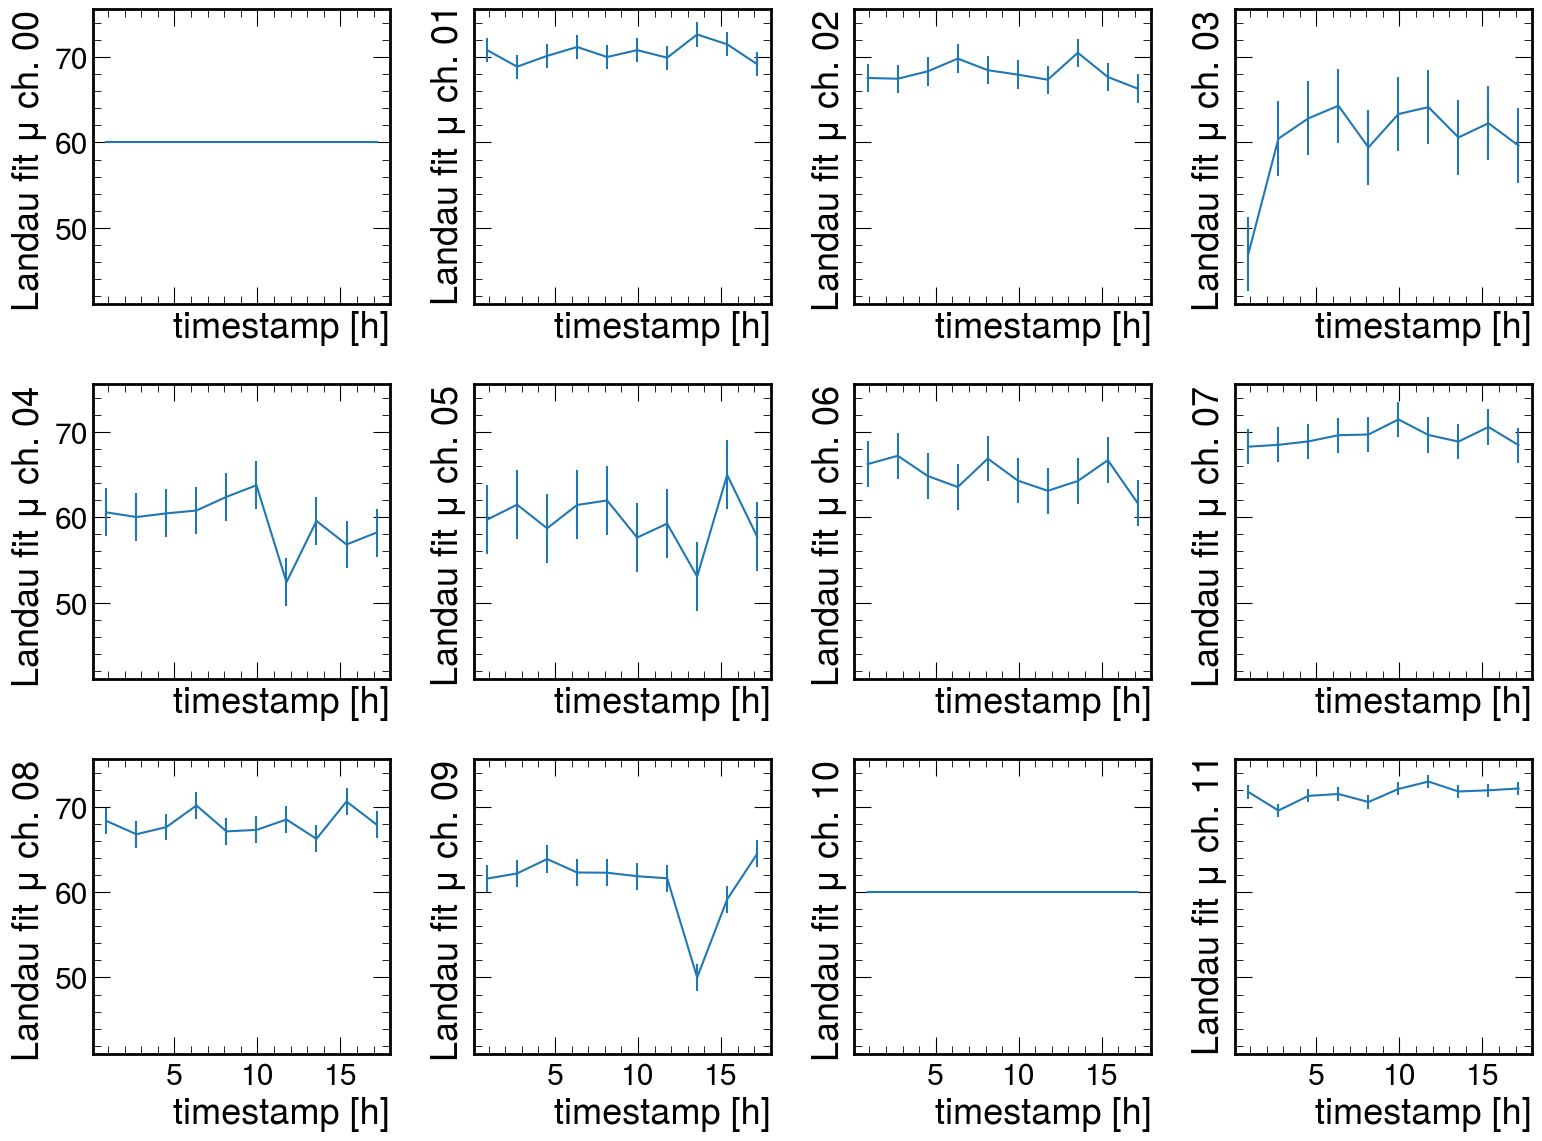

In [124]:
fig, axs=plt.subplots(3,4, figsize=(16, 16/4*3),sharex='all', sharey='all')

for i in range(len(channels)):
    ch = channels[i]
    plt.sca(axs[i//4][i%4])
    slices = np.linspace(0, max(df.timestamp), 11)
    mus=[]
    dmus=[]
    centers=[]
    for j in range(len(slices)-1):
        hist,x,= np.histogram(df.query(f"timestamp>{slices[j]} and timestamp<{slices[j+1]}")\
                              .eval(f"Ch_{ch}_LG"), bins=26, range=(20,200))
        

        bin_centers=(x[1:]+x[:-1])/2

        from scipy.optimize import curve_fit
        start,stop=5,-10
        p0=[1000, 60, 10]

        #plt.errorbar(bin_centers, hist, np.sqrt(hist), linestyle='', marker='o', label='data')

        dhist=np.sqrt(hist[start:stop])+(hist[start:stop]==0)
        coeff, var_matrix = curve_fit(Landau, bin_centers[start:stop], hist[start:stop], p0=p0,
                                 sigma=dhist)
        from scipy.stats import chi2
        chi2val = sum((Landau(bin_centers[start:stop], *coeff)-hist[start:stop])**2/dhist**2)
        ndof = len(bin_centers[start:stop])-len(coeff)
        print("chi2=",chi2val, "ndof=",ndof, "pval=", chi2.sf(chi2val, ndof))
        x=np.linspace(0, 140, 280)
        mu=coeff[1]
        dmu=np.sqrt(var_matrix[1][1])
        mus.append(mu)
        dmus.append(dmu)
        centers.append((slices[j]+slices[j+1])/2)
    plt.errorbar(np.array(centers)/(3.6e9), mus, dmu)
    plt.xlabel(f"timestamp [h]")
    plt.ylabel(f"Landau fit $\mu$ ch. {ch}")
    
plt.tight_layout()